<a href="https://colab.research.google.com/github/jonathanahc/PLN_Practicas/blob/main/Proyecto_Final_Jonathan_Herrera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Monta Google Drive en Colab para poder leer archivos desde la unidad
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
#Importación de librerías
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from wordcloud import WordCloud
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# **Carga del dataset**

In [ ]:
# Carga el archivo CSV desde Google Drive en un DataFrame llamado df
df = pd.read_csv('/content/drive/MyDrive/PLN/ProyectoFinal/Dataset.csv', engine = 'python')

# **Análisis exploratorio (EDA)**

In [ ]:
#Muestra los primeros cinco registros del dataframe
df.head()

,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound


In [ ]:
#Muestra los últimos cinco registros del dataframe
df.tail()

,phrase,prompt
6656,I feel a burning sensation in my guts about 2 ...,Stomach ache
6657,I have a split on my thumb that will not heal.,Open wound
6658,I feel a lot of pain in the joints.,Joint pain
6659,The area around my heart doesn't feel good.,Heart hurts
6660,I complain alot with skin allergy,Skin issue


In [ ]:
# Imprime el número de filas y columnas del DataFrame
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

Filas: 6661, Columnas: 2


In [ ]:
# Muestra información general del DataFrame (tipos de datos, valores no nulos, etc.)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  6661 non-null   object
 1   prompt  6661 non-null   object
dtypes: object(2)
memory usage: 104.2+ KB


In [ ]:
# Muestra estadísticas descriptivas de las columnas numéricas (media, desviación, etc.)
df.describe()

,phrase,prompt
count,6661,6661
unique,706,25
top,When I stand up too quickly I start to feel di...,Acne
freq,35,328


In [ ]:
# Cuenta cuántos valores faltantes (NaN) hay en cada columna
df.isna().sum()

,0
phrase,0
prompt,0


In [ ]:
# Calcula la moda (valor más frecuente) de cada columna y toma la primera fila de resultados
moda = df.mode().iloc[0]
moda

,0
phrase,When I stand up too quickly I start to feel di...
prompt,Acne


In [ ]:
# Calcula cuántas veces aparece cada texto en la columna 'phrase'
df['phrase'].value_counts()

,count
phrase,
When I stand up too quickly I start to feel dizzy and light-headed,35
There is a sharp pain in my bicep. I have tried to apply pain relief cream but it does not help.,18
I feel like the room is spinning,15
I can't do anything I feel a weak in my body,12
is my cut infected or just healing?,12
...,...
I have muscle pain in my left leg,1
i have muscle pain that my back\nI Have Muscle Pain at my back leg,1
My muscles in my lower back are aching,1


In [ ]:
# Calcula cuántas veces aparece cada texto en la columna 'prompt'
df['prompt'].value_counts()

,count
prompt,
Acne,328
Shoulder pain,320
Joint pain,318
Infected wound,306
Knee pain,305
Cough,293
Feeling dizzy,283
Muscle pain,282
Heart hurts,273


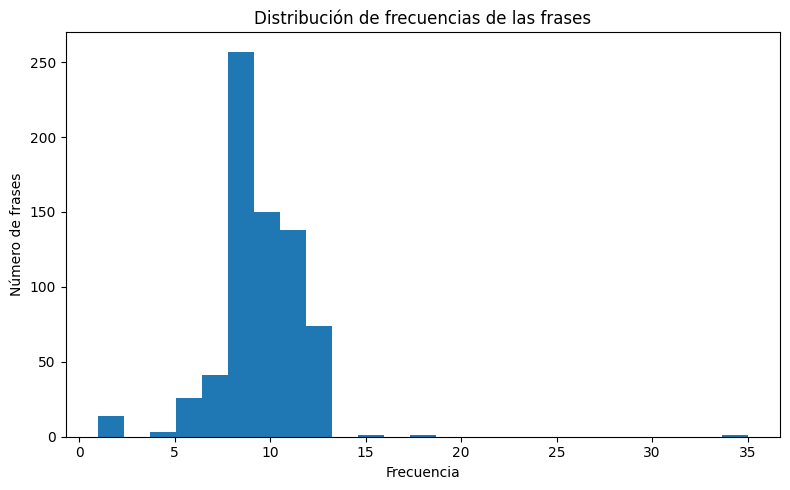

In [ ]:
# Calcula cuántas veces aparece cada texto en la columna 'phrase'
phrase_conteo = df['phrase'].value_counts()

#Gráfica la distribución de las frases
plt.figure(figsize=(8, 5))
plt.hist(phrase_conteo, bins=25)
plt.title('Distribución de frecuencias de las frases')
plt.xlabel('Frecuencia')
plt.ylabel('Número de frases')
plt.tight_layout()
plt.show()

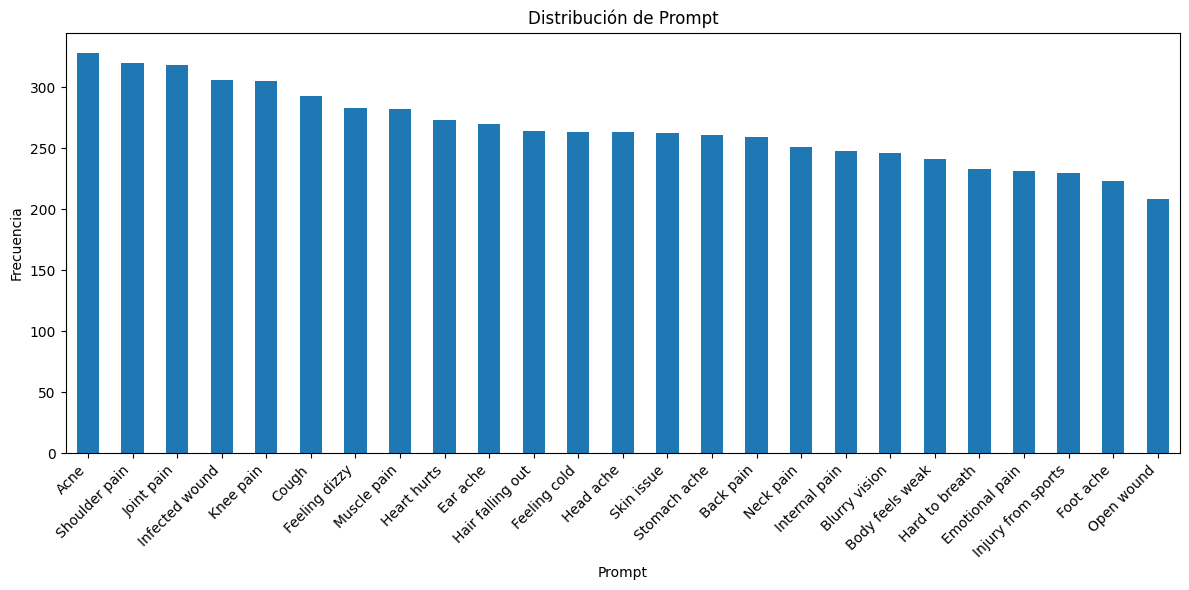

In [ ]:
# Calcula cuántas veces aparece cada texto en la columna 'prompt'
prompt_conteo = df['prompt'].value_counts()

# Gráfica la distribución de las etiquetas de 'Prompt'
plt.figure(figsize=(12, 6))
prompt_conteo.plot(kind='bar')
plt.title('Distribución de Prompt')
plt.xlabel('Prompt')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Preprocesamiento y normalización**

In [ ]:
# Define una función para limpiar texto crudo y normalizarlo
def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = texto.replace("\n", " ")
    texto = re.sub(r"[^a-z0-9'\s]", " ", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    texto = unidecode(texto)
    return texto

# Aplica la función de limpieza a la columna 'phrase'
df['phrase'] = df['phrase'].apply(limpiar_texto)

# Aplica la función de limpieza a la columna 'prompt'
df['prompt'] = df['prompt'].apply(limpiar_texto)

In [ ]:
# Muestra los primeros diez registros del dataframe normalizado
df.head(10)

,phrase,prompt
0,when i remember her i feel down,emotional pain
1,when i carry heavy things i feel like breaking...,hair falling out
2,there is too much pain when i move my arm,heart hurts
3,my son had his lip pierced and it is swollen a...,infected wound
4,my muscles in my lower back are aching,infected wound
5,i have muscle pain that my back i have muscle ...,foot ache
6,i have muscle pain in my left leg,shoulder pain
7,i have cut my finger because of playing footba...,injury from sports
8,i have acne in my face and other problems in m...,skin issue
9,i have a strange rash on my arm,foot ache


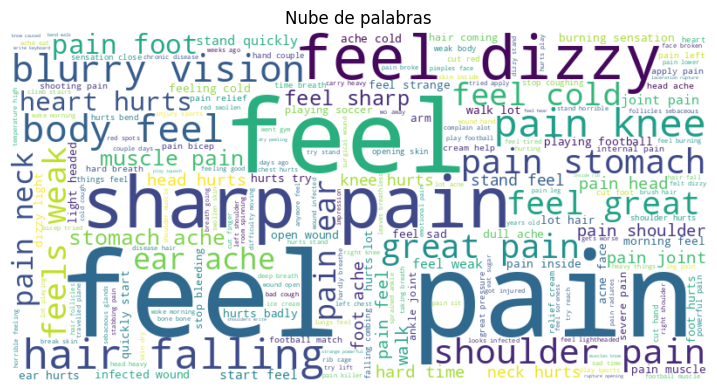

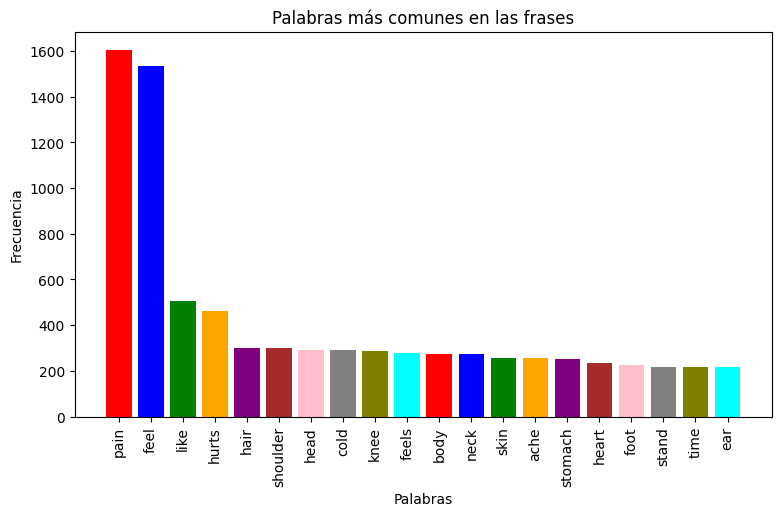

In [ ]:
# Define una función para generar nube de palabras y barras de palabras frecuentes
def stopwords_con_spacy(dataframe, columna):
  nlp = spacy.load("en_core_web_sm")
  doc = dataframe[columna].apply(nlp)

  # Recorre cada documento y token, quedándote solo con palabras que:
  # - No sean stopwords
  # - Sean alfabéticas (sin números ni símbolos)
  stopwords = [token.text for doc in doc for token in doc if not token.is_stop and token.is_alpha]

  # Une todas las palabras filtradas en un solo string separado por espacios
  texto_stop = ' '.join(stopwords)

  # Genera una nube de palabras a partir del texto
  wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(texto_stop)
  plt.figure(figsize=(9, 5))
  plt.title('Nube de palabras')
  plt.imshow(wordcloud1, interpolation='bilinear')
  plt.axis('off')
  plt.show()

  #Crea un contador de frecuencias para posteriormente crear un gráfico de barras con estas frecuencias
  conteo = Counter(stopwords)
  comun = conteo.most_common(20)
  palabras, freqs = zip(*comun)
  colores = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
  plt.figure(figsize=(9,5))
  plt.bar(palabras, freqs, color=colores)
  plt.title('Palabras más comunes en las frases')
  plt.xlabel('Palabras')
  plt.ylabel('Frecuencia')
  plt.xticks(rotation=90)
  plt.show()

# Llama a la función usando la columna 'phrase' del DataFrame
stopwords_con_spacy(df, 'phrase')

# **Generación de representaciones vectoriales**

In [ ]:
# Convierte cada frase en una lista de tokens (palabras separadas por espacio)
docs_phrase = [doc.split() for doc in df['phrase']]

In [ ]:
# Crea y entrena el modelo Word2Vec con las frases tokenizadas
w2v = Word2Vec(
    sentences = docs_phrase,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    negative=10,
    epochs=10,
    seed=42
  )

In [ ]:
# Define una función para convertir una lista de tokens en un solo vector
def doc_to_vec(tokens, model):

    # Obtiene los vectores de las palabras que sí existen en el vocabulario del modelo
    vecs = [model.wv[w] for w in tokens if w in model.wv]

    # Si no hay ninguna palabra válida, devuelve un vector de ceros
    if len(vecs) == 0:
        return np.zeros(model.vector_size)

    # Calcula el promedio de todos los vectores de las palabras del documento
    return np.mean(vecs, axis=0)

# Aplica la función doc_to_vec a cada documento de docs_phrase para crear la matriz X
X = np.vstack([doc_to_vec(doc, w2v) for doc in docs_phrase])

# Define y como la variable objetivo (la clase), usando la columna 'prompt'
y = df['prompt']

# **Entrenamiento de tres modelos distintos y optimización**

In [ ]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.3,
  random_state=42,
  stratify=y
)

In [143]:
# Diccionario que contiene la configuración de los modelos y sus hiperparámetros

modelos = {
    # Modelo de Regresión Logística
    "log_reg": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=1000))
        ]),
        # Rejilla de parámetros para la regresión logística
        "param_grid": {
            "clf__C": [0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"]
        }
    },
    # Modelo SVM lineal
    "svc_lineal": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LinearSVC())
        ]),
        # Rejilla de parámetros para LinearSVC
        "param_grid": {
            "clf__C": [0.1, 1, 10]
        }
    },
    # Modelo Random Forest
    "random_forest": {
        "estimator": RandomForestClassifier(random_state=42),
        # Rejilla de parámetros para Random Forest
        "param_grid": {
            "n_estimators": [100, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    }
}

# Define un esquema de validación cruzada estratificada con 10 particiones
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Diccionario para almacenar los mejores modelos encontrados por GridSearchCV
mejores_modelos = {}

# Recorre cada modelo definido en el diccionario 'modelos'
for nombre, cfg in modelos.items():

  print(f"\n********************* Entrenamiento con {nombre} *********************")

  scoring = {
    'accuracy':'accuracy',
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
  }

  # Crea el objeto GridSearchCV para búsqueda de parámetros
  grid = GridSearchCV(
      estimator=cfg["estimator"],
      param_grid=cfg["param_grid"],
      cv=cv_10,
      scoring=scoring,
      refit='f1_macro',
      n_jobs=-1
  )

  # Ajusta el GridSearchCV con los datos de entrenamiento
  grid.fit(X_train, y_train)

  print("Mejores parámetros:", grid.best_params_)
  print("Mejor score:", grid.best_score_)

  # Guarda el mejor modelo encontrado en el diccionario de mejores modelos
  mejores_modelos[nombre] = grid.best_estimator_

  # Realiza predicciones sobre el conjunto de prueba usando el mejor modelo
  y_pred = grid.predict(X_test)
  print("\nReporte:")
  print(classification_report(y_test, y_pred))


********************* Entrenamiento con log_reg *********************
Mejores parámetros: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Mejor score: 0.9976133595445837

Reporte:
                    precision    recall  f1-score   support

              acne       1.00      1.00      1.00        99
         back pain       1.00      1.00      1.00        78
     blurry vision       1.00      1.00      1.00        74
   body feels weak       1.00      0.99      0.99        72
             cough       1.00      1.00      1.00        88
          ear ache       1.00      1.00      1.00        81
    emotional pain       1.00      1.00      1.00        69
      feeling cold       1.00      1.00      1.00        79
     feeling dizzy       1.00      1.00      1.00        85
         foot ache       1.00      1.00      1.00        67
  hair falling out       0.99      1.00      0.99        79
    hard to breath       1.00      1.00      1.00        70
         head ache       

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mejores parámetros: {'clf__C': 10}
Mejor score: 0.9978366941307091

Reporte:
                    precision    recall  f1-score   support

              acne       1.00      1.00      1.00        99
         back pain       1.00      1.00      1.00        78
     blurry vision       1.00      1.00      1.00        74
   body feels weak       1.00      0.99      0.99        72
             cough       1.00      1.00      1.00        88
          ear ache       1.00      1.00      1.00        81
    emotional pain       1.00      1.00      1.00        69
      feeling cold       1.00      1.00      1.00        79
     feeling dizzy       1.00      1.00      1.00        85
         foot ache       1.00      1.00      1.00        67
  hair falling out       0.99      1.00      0.99        79
    hard to breath       1.00      1.00      1.00        70
         head ache       1.00      1.00      1.00        79
       heart hurts       1.00      1.00      1.00        82
    infected wound    

**Mejor modelo**

In [ ]:
"""El mejor modelo es: RandomForestClassifier

El mejor score obtenido fue: 100

Basado en el resultado anterior, el modelo con el mejor score (f1_macro) fue RandomForestClassifier con un score de 0.9978578941891186.
Los mejores parámetros para Random Forest fueron: max_depth=20, min_samples_split=2, n_estimators=300
Mejores parámetros para Random Forest (obtenidos del output de entrenamiento): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}

En resumen, este modelo obtuvo los mejores resultados por lo tanto se considera el mejor."""